In [1]:
# CELL 1 — Drive mount (Colab এ প্রথম চালান)
from google.colab import drive
drive.mount('/content/drive')

# (Run this cell and follow the prompt to allow Drive access)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# CELL 2 — প্রয়োজনীয় লাইব্রেরি ও dataset চেক (একবার চালান)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

dataset_path = '/content/drive/MyDrive/animals'   # আপনার path যদি ভিন্ন হয় এখানে পরিবর্তন করুন
print("Dataset path:", dataset_path)
print("Folders:", os.listdir(dataset_path))
for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    print(cls, "->", len(os.listdir(cls_path)), "images (showing up to 5):", os.listdir(cls_path)[:5])

Dataset path: /content/drive/MyDrive/animals
Folders: ['dogs', 'panda', 'cats']
dogs -> 150 images (showing up to 5): ['dogs_00120.jpg', 'dogs_00017.jpg', 'dogs_00080.jpg', 'dogs_00026.jpg', 'dogs_00057.jpg']
panda -> 150 images (showing up to 5): ['panda_00028.jpg', 'panda_00025.jpg', 'panda_00012.jpg', 'panda_00006.jpg', 'panda_00013.jpg']
cats -> 150 images (showing up to 5): ['cats_00001.jpg', 'cats_00004.jpg', 'cats_00002.jpg', 'cats_00003.jpg', 'cats_00005.jpg']


In [3]:
# CELL 3 — NeuralNetwork class (সহজ: Conv -> Flatten -> 2 hidden Dense -> output)
class NeuralNetwork:
    def __init__(self, input_shape=(64,64,3), num_classes=3, hidden1=64, hidden2=32, lr=1e-3):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.lr = lr
        self.model = self.build_model()
    def build_model(self):
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D((2,2)),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D((2,2)),
            Flatten(),
            Dense(self.hidden1, activation='relu'),   # hidden layer 1
            Dropout(0.4),
            Dense(self.hidden2, activation='relu'),   # hidden layer 2
            Dropout(0.3),
            Dense(self.num_classes, activation='softmax')
        ])
        return model
    def compile(self):
        opt = Adam(learning_rate=self.lr)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    def train(self, train_gen, val_gen, epochs=10):
        history = self.model.fit(train_gen, validation_data=val_gen, epochs=epochs)
        return history
    def save(self, path):
        self.model.save(path)

In [4]:
# CELL 4 — Data generators এবং training (একবার চালান)
img_h, img_w = 64, 64
batch_size = 16
epochs = 8           # প্রথমে কম epoch দিয়ে চালান; পরে বাড়ান
classes = ['dogs','cats','panda']   # আপনার ফোল্ডার নেমগুলো মিলিয়ে নিন

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    classes=classes,
    class_mode='categorical',
    subset='training',
    shuffle=True, seed=100
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    classes=classes,
    class_mode='categorical',
    subset='validation',
    shuffle=False, seed=100
)

# Model তৈরি, compile ও train
NN = NeuralNetwork(input_shape=(img_h,img_w,3), num_classes=len(classes), hidden1=128, hidden2=64, lr=1e-3)
NN.compile()
NN.model.summary()

history = NN.train(train_gen, val_gen, epochs=epochs)

Found 360 images belonging to 3 classes.
Found 87 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,633,603 (6.23 MB)

 Trainable params: 1,633,603 (6.23 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.3451 - loss: 1.1738 - val_accuracy: 0.3333 - val_loss: 1.0663
Epoch 2/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.4180 - loss: 1.0395 - val_accuracy: 0.4598 - val_loss: 0.9676
Epoch 3/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.5241 - loss: 0.9525 - val_accuracy: 0.5402 - val_loss: 0.8775
Epoch 4/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.6209 - loss: 0.8563 - val_accuracy: 0.5862 - val_loss: 0.8007
Epoch 5/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.6579 - loss: 0.7069 - val_accuracy: 0.6092 - val_loss: 0.7649
Epoch 6/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.6581 - loss: 0.7140 - val_accuracy: 0.6207 - val_loss: 0.7472
Epoch 7/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.7059 - loss: 0.5904 - val_accuracy: 0.6092 - val_loss: 0.7173
Epoch 8/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.7958 - loss: 0.4883 - val_accuracy: 0.6207 - v

Model saved to: /content/drive/MyDrive/animals_simple_model.h5


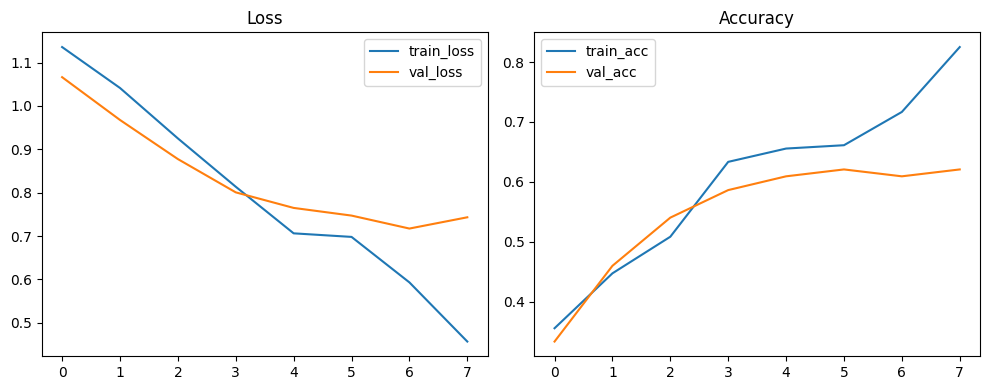

In [5]:
# CELL 5 — Save model ও training plot (চালান)
save_path = '/content/drive/MyDrive/animals_simple_model.h5'
NN.save(save_path)
print("Model saved to:", save_path)

# Plot history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.tight_layout()
plt.show()